To do : 
- We stay on the "full" version of the data for now (with baseline) 
- Find a set of parameters for the TF analysis that doesn't include every time points, for example 20 ms  ; then the temporal dimension should look like : 40 to 60 ms, 60 to 80 ms, 80 to 100 ms, 100 to 120 ms, 120 to 140 ms for the post stim
- Perform clustering analysis separately for each of these 20 ms wide time windows, on phase / frequency data
- frequency domain : 8 Hz to 28 Hz 
- How to go to the group level ? If we find clusters, we could use centroids the group level.




In [4]:
import scipy.io as sio
from matplotlib import pyplot as plt 
%matplotlib inline


In [13]:
#matfile = '/run/media/nfarrugi/ECHACHACHOU/PD_phase/data_probands_beta_noselec_p50_Cz_6_Hz.mat'
matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/spectrum-beta-29feb2016/2017/wideband/data_probands_beta_noselec_p50_Cz.mat'

In [14]:
filecontents = sio.whosmat(matfile)
print(filecontents)

[('plv_subj_01k1', (1, 1), 'struct'), ('plv_subj_02k1', (1, 1), 'struct'), ('plv_subj_03k1', (1, 1), 'struct'), ('plv_subj_04k1', (1, 1), 'struct'), ('plv_subj_05k1', (1, 1), 'struct'), ('plv_subj_06k1', (1, 1), 'struct'), ('plv_subj_07k1', (1, 1), 'struct'), ('plv_subj_08k1', (1, 1), 'struct'), ('plv_subj_09k1', (1, 1), 'struct'), ('plv_subj_10k1', (1, 1), 'struct'), ('plv_subj_11k1', (1, 1), 'struct'), ('plv_subj_12k1', (1, 1), 'struct'), ('plv_subj_13k1', (1, 1), 'struct'), ('plv_subj_14k1', (1, 1), 'struct'), ('plv_subj_15k1', (1, 1), 'struct'), ('plv_subj_16k1', (1, 1), 'struct'), ('plv_subj_17k1', (1, 1), 'struct'), ('plv_subj_18k1', (1, 1), 'struct'), ('plv_subj_19k1', (1, 1), 'struct'), ('plv_subj_20k1', (1, 1), 'struct')]


Let's pick one subject randomly

In [376]:
import numpy as np 

cursubjname = filecontents[np.random.randint(20)][0]
print(cursubjname)

plv_subj_09k1


Load this subject

In [183]:
subjdata = sio.loadmat(matfile,variable_names=cursubjname,struct_as_record = False,squeeze_me=True)[cursubjname]

We can now directly access all the fields of the struct directly like in Matlab

In [184]:
subjdata.all.iso.standard.time

array([-0.2 , -0.18, -0.16, -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04,
       -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,
        0.16,  0.18,  0.2 ])

In [185]:
allfreqs  = np.round(subjdata.all.iso.standard.freq)
print(allfreqs)

[  8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.
  23.  24.  25.  26.  27.  28.]


In [41]:
subjdata.all.iso.standard.label

array(['Fz', 'Cz', 'Pz'], dtype=object)

We choose the time point here

In [363]:
tpoint = 14

tpoint_ms = subjdata.all.iso.standard.time[tpoint]
p50_cz_iso_std = subjdata.all.iso.standard.ang[:,1,:,tpoint]
p50_cz_rnd_std = subjdata.all.rnd.standard.ang[:,1,:,tpoint]

print("Examining at %0.2f ms" % tpoint_ms)

Examining at 0.08 ms


Clustering tests on raw angle data 
--

In this section, we are doing some basic clustering tests on specific time points, by looking at distributions of frequencies - at one specific time point, we see frequencies as features, and investigate whether the variability across trials can distinguish REGULAR vs IRREGULAR

The dimensionality of our is 21 (21 frequencies). We will attempt to use manifold learning methods in order to visualize the phase-frequency in a low-dimensional space (2 or 3). 

**Thus we are directly trying to identify clusters in a low-dimensional space**

*Dimensionality reduction*  using Local Tangent Space Alignement (LTSA). 

(“Principal manifolds and nonlinear dimensionality reduction via tangent space alignment” Zhang, Z. & Zha, H. Journal of Shanghai Univ. 8:406 (2004)) 


Learning 2D projections 
--

Red points : REGULAR 

Grey points : IRREGULAR

Controls

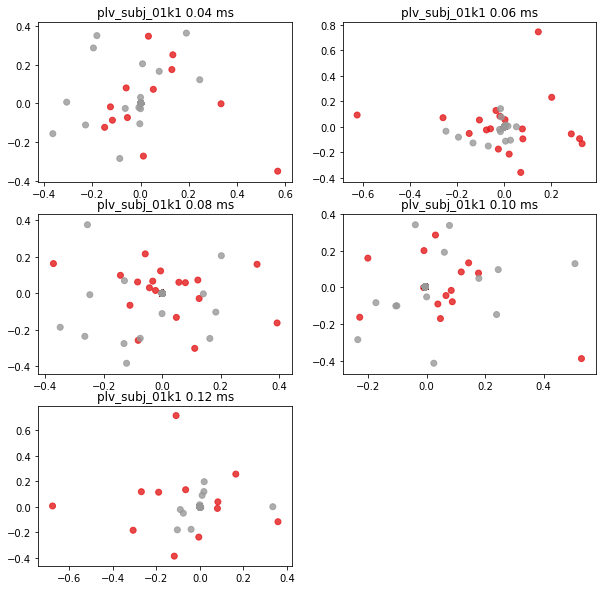

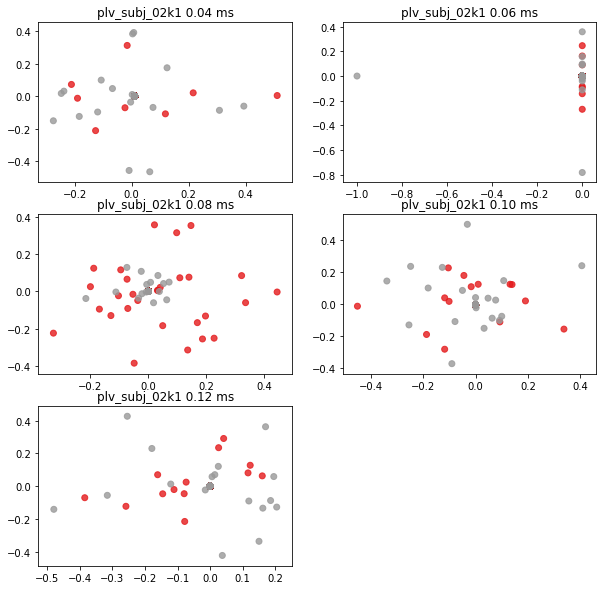

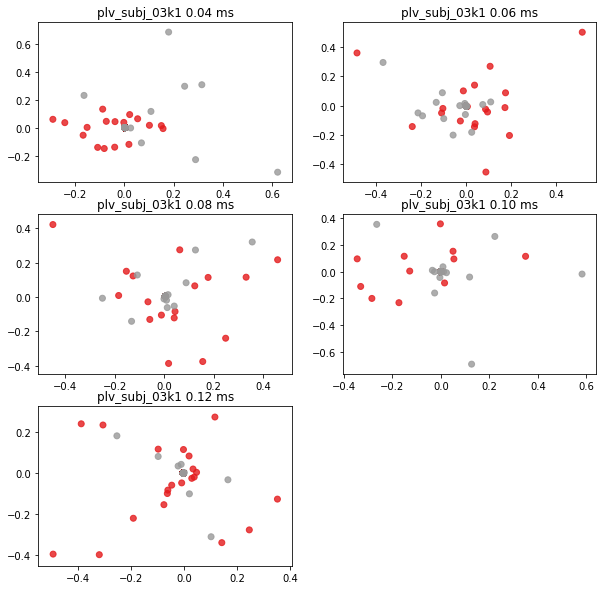

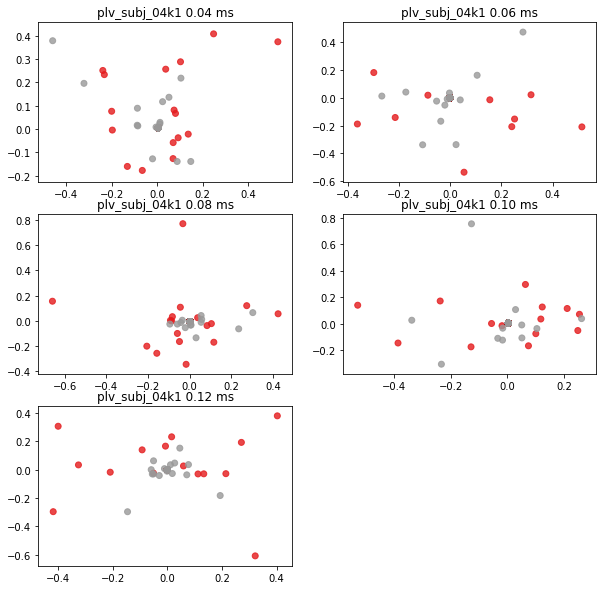

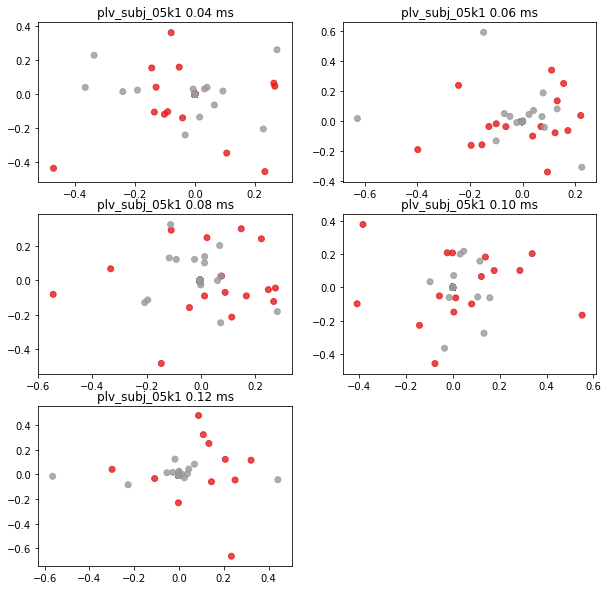

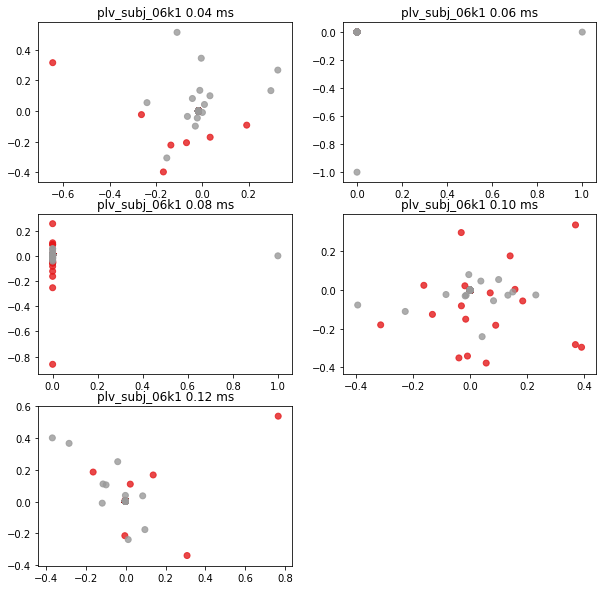

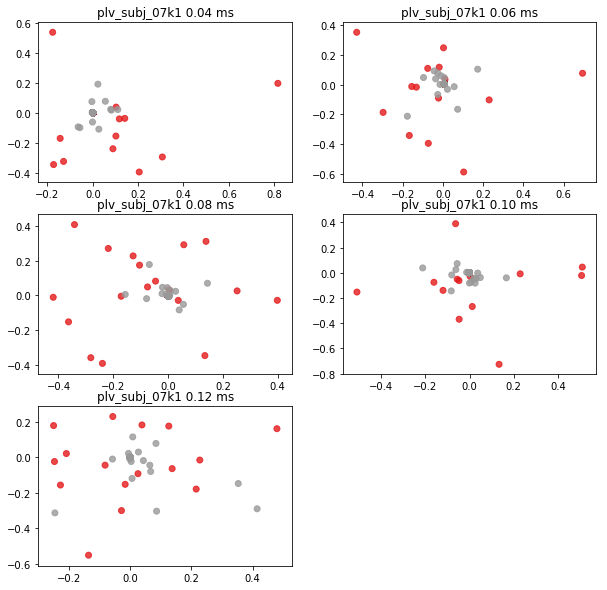

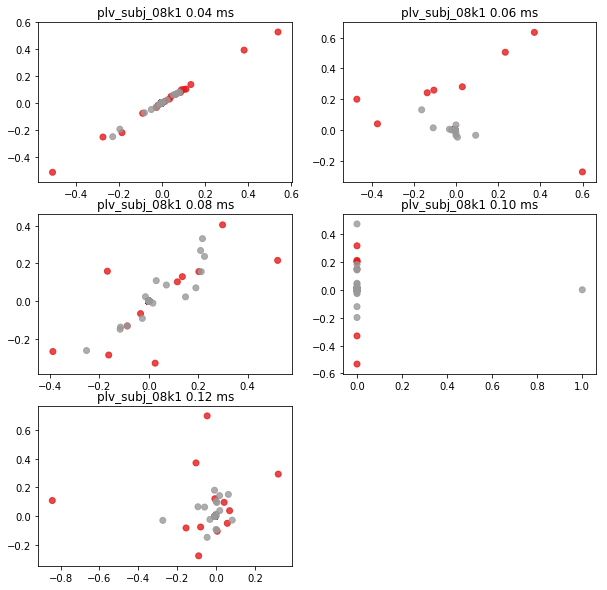

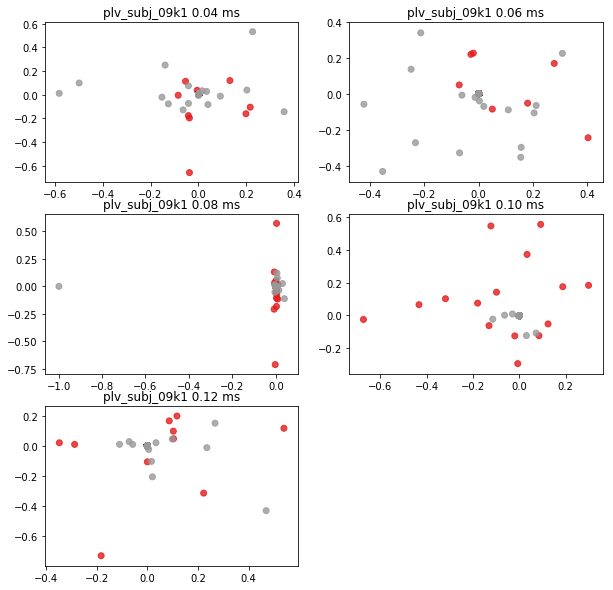

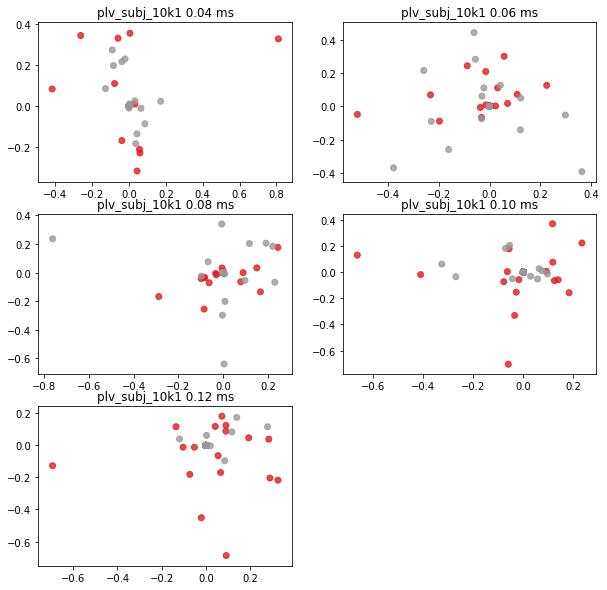

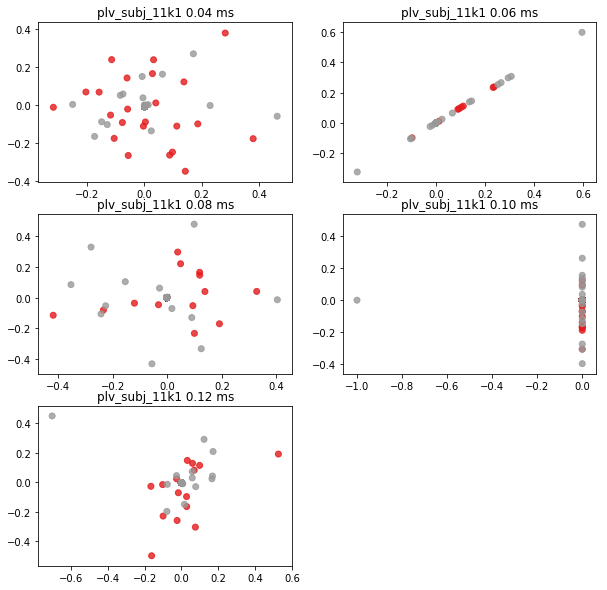

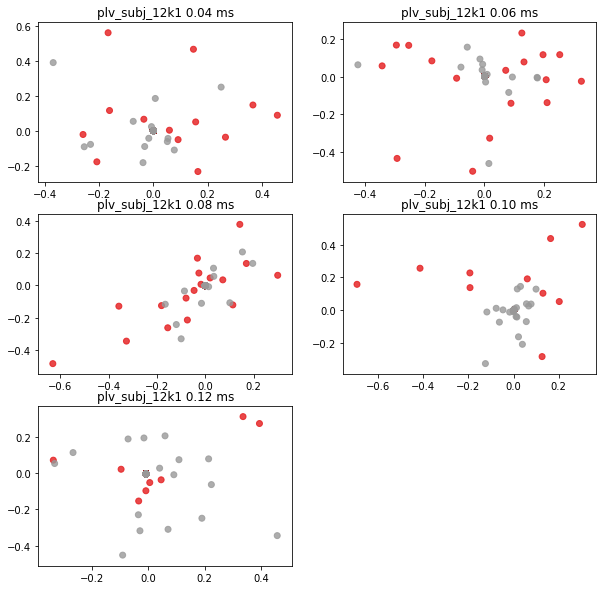

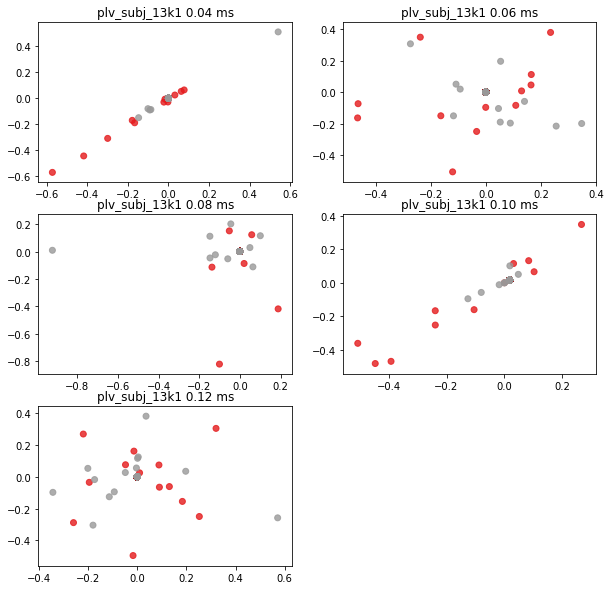

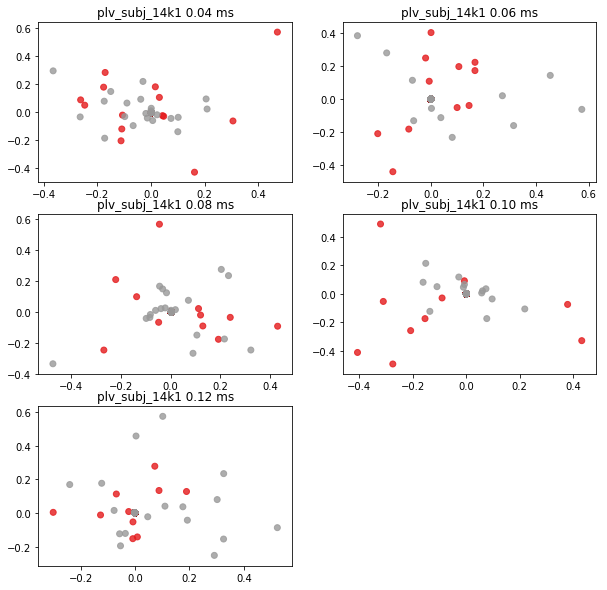

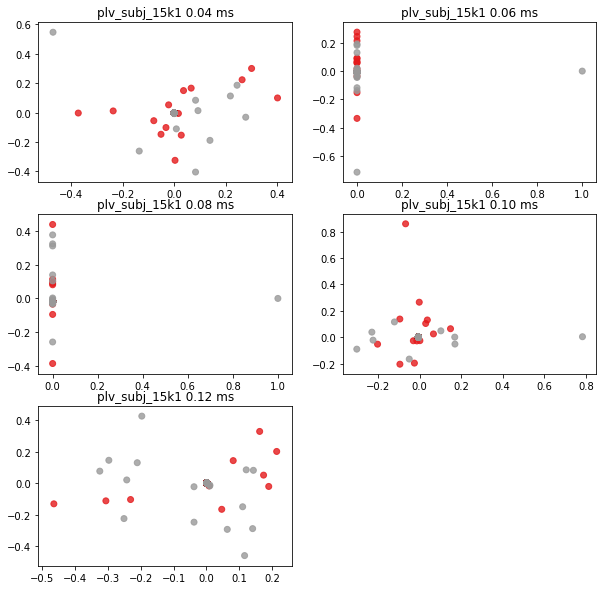

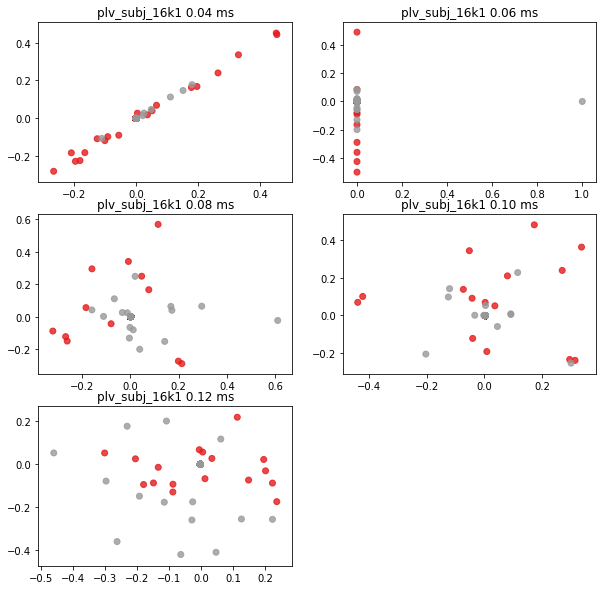

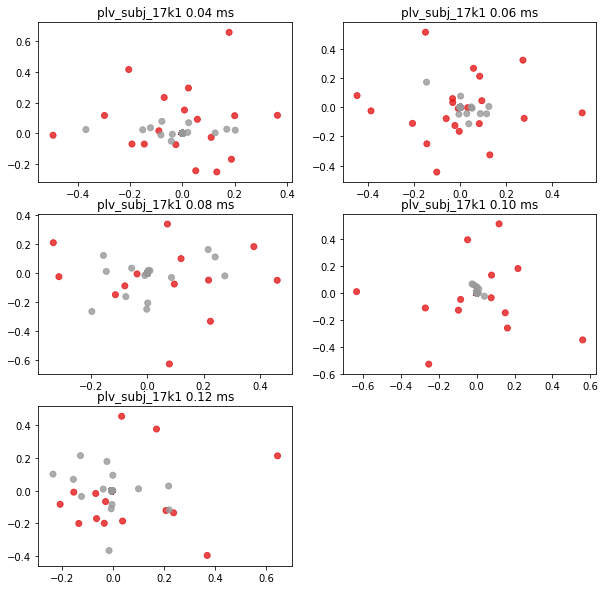

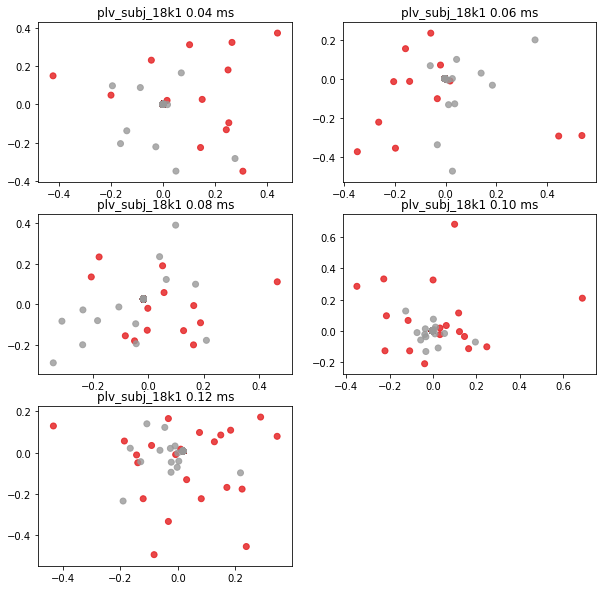

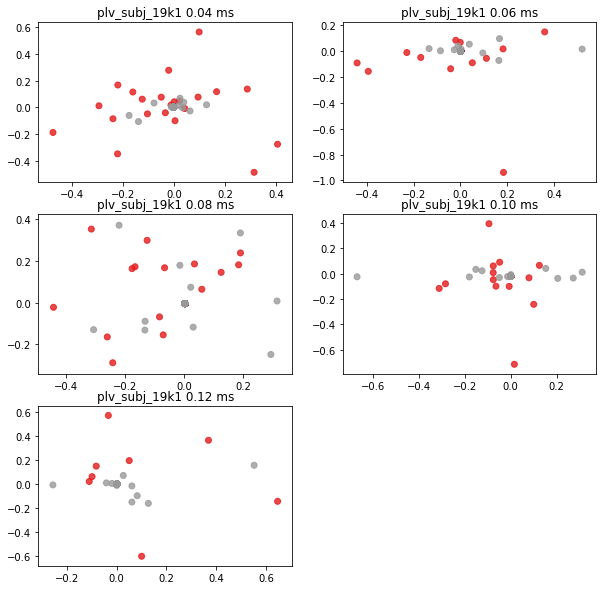

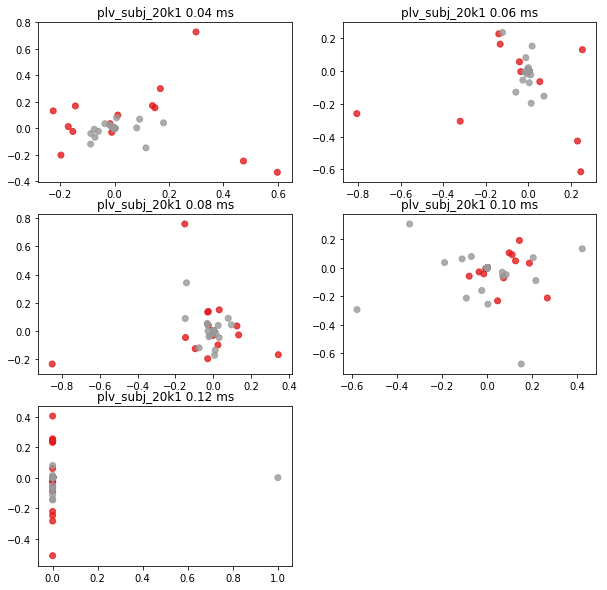

In [412]:
matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/spectrum-beta-29feb2016/2017/wideband/data_probands_beta_noselec_p50_Cz.mat'

filecontents = sio.whosmat(matfile)

for cursubjname in filecontents:
    current_subj = (cursubjname[0])
    subjdata = sio.loadmat(matfile,variable_names=current_subj,struct_as_record = False,squeeze_me=True)[current_subj]
    plt.figure(figsize=(10,10))
    
    for k,tpoint in enumerate(range(12,17)):

        tpoint_ms = subjdata.all.iso.standard.time[tpoint]
        p50_cz_iso_std = subjdata.all.iso.standard.ang[:,2,:,tpoint]
        p50_cz_rnd_std = subjdata.all.rnd.standard.ang[:,2,:,tpoint]

        #print("Examining at %0.2f ms" % tpoint_ms)

        n_iso = p50_cz_iso_std.shape[0]
        n_rnd = p50_cz_rnd_std.shape[0]
        #print(n_iso,n_rnd)

        y = 2*np.ones(n_iso+n_rnd)
        y[0:n_iso]=1

        X = (np.vstack([p50_cz_iso_std,p50_cz_rnd_std]))


        from sklearn.manifold import LocallyLinearEmbedding,Isomap,MDS,TSNE,SpectralEmbedding
        n_neighbors = 8
        n_components = 2

        plt.subplot(3,2,k+1)


        #Y = SpectralEmbedding(n_neighbors=n_neighbors,n_components=n_components,affinity='rbf').fit_transform(X)
        Y = LocallyLinearEmbedding(n_neighbors,n_components=n_components,method='ltsa',eigen_solver='dense').fit_transform(X)

        plt.scatter(Y[:, 0], Y[:, 1],c=y,alpha=0.8,cmap=plt.cm.Set1)
        plt.title('%s %0.2f ms' % (current_subj,tpoint_ms))

Patients

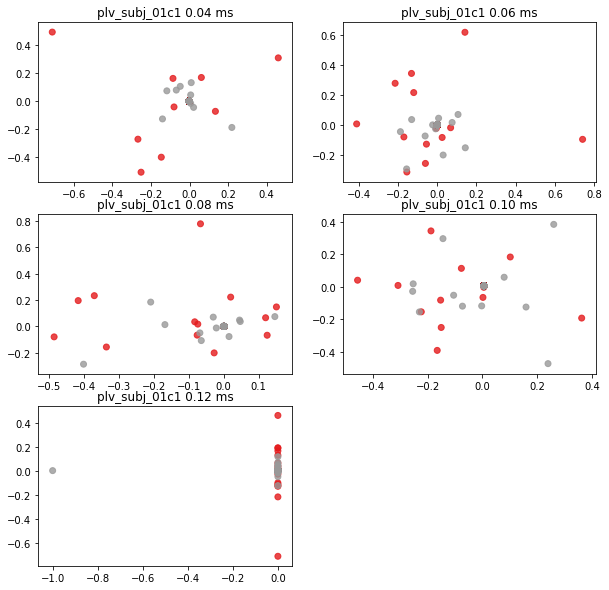

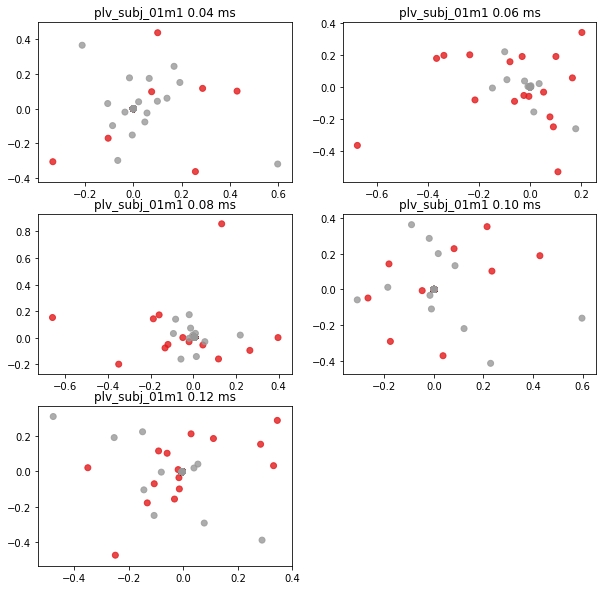

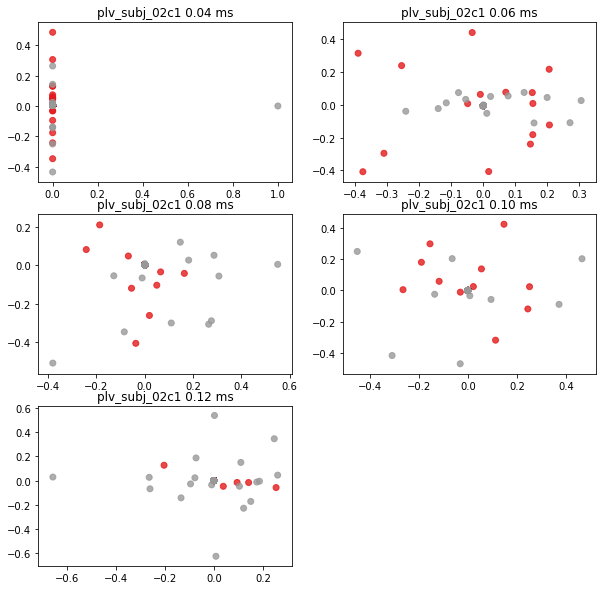

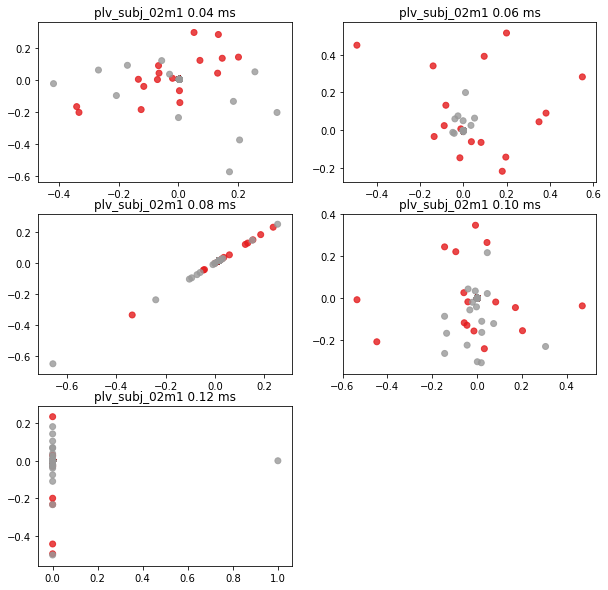

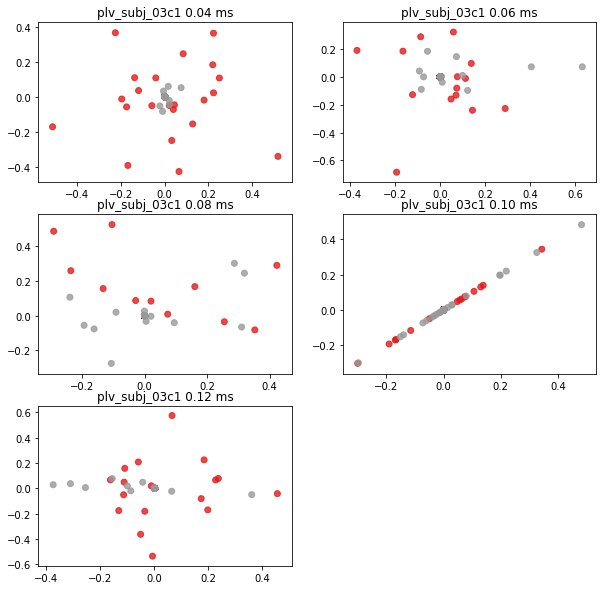

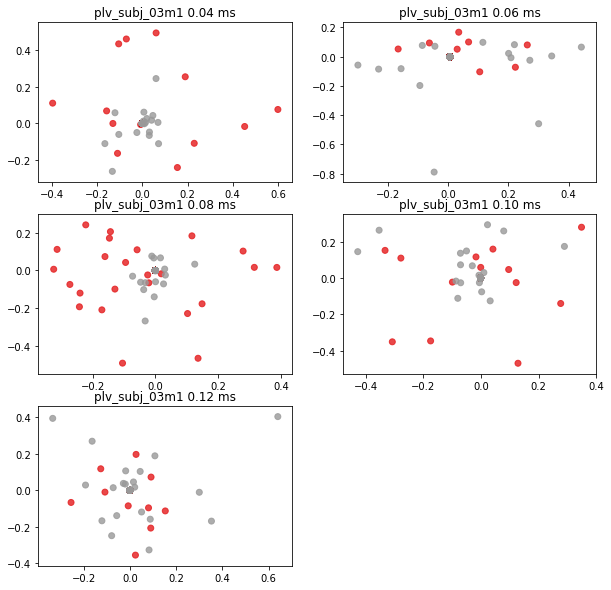

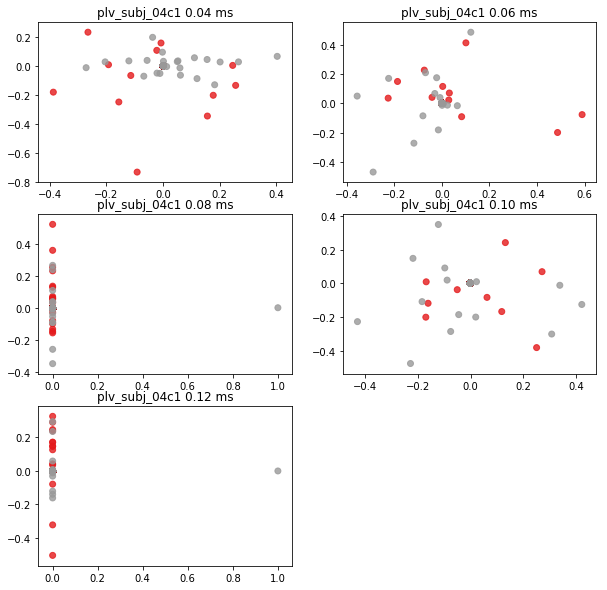

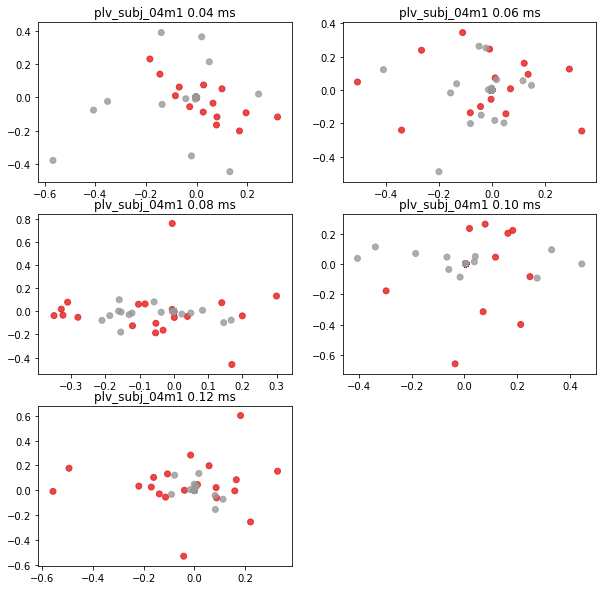

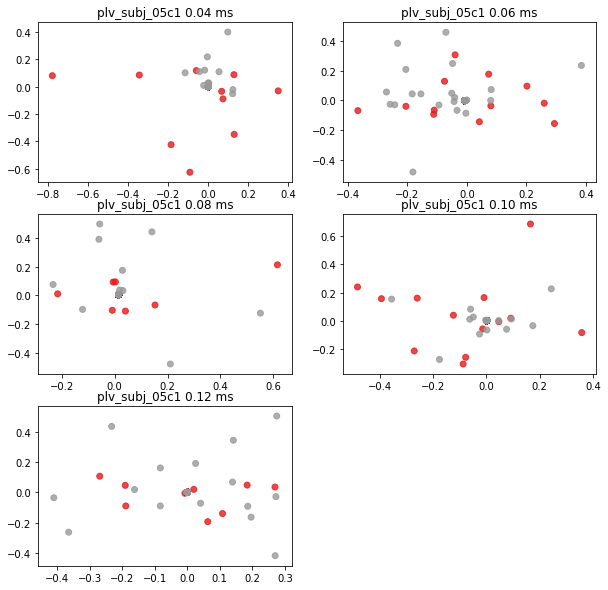

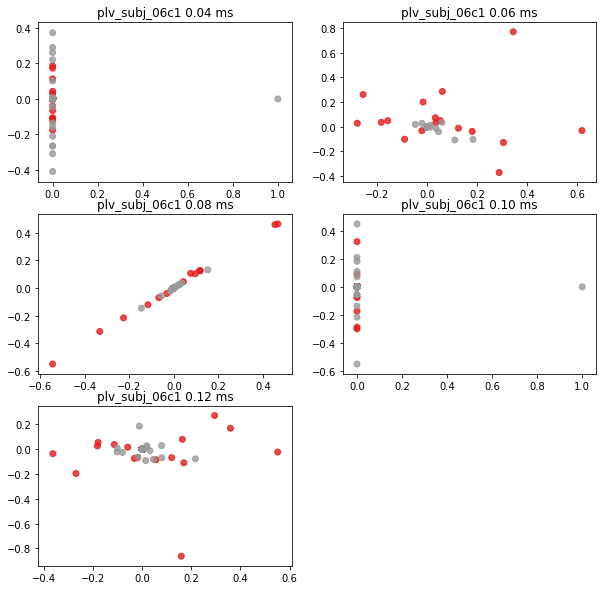

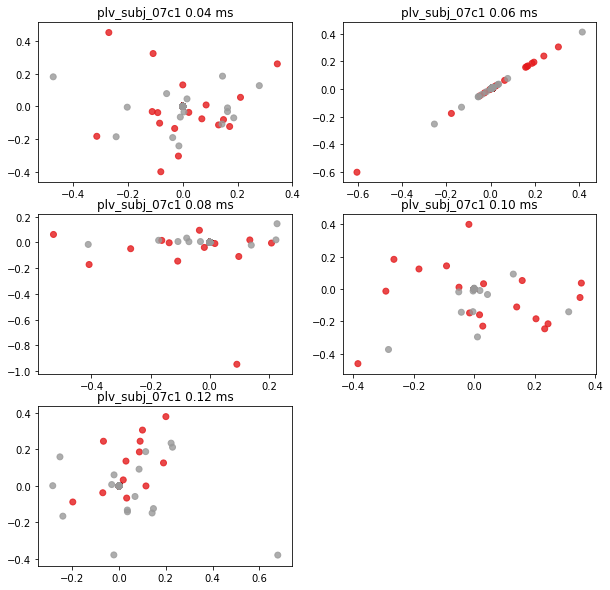

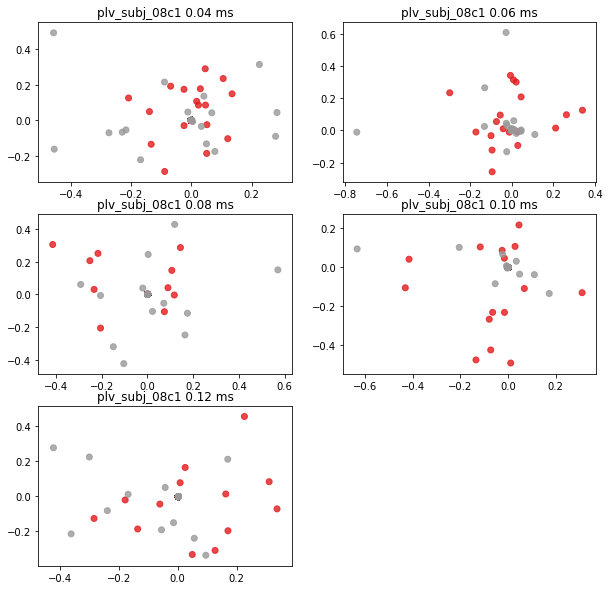

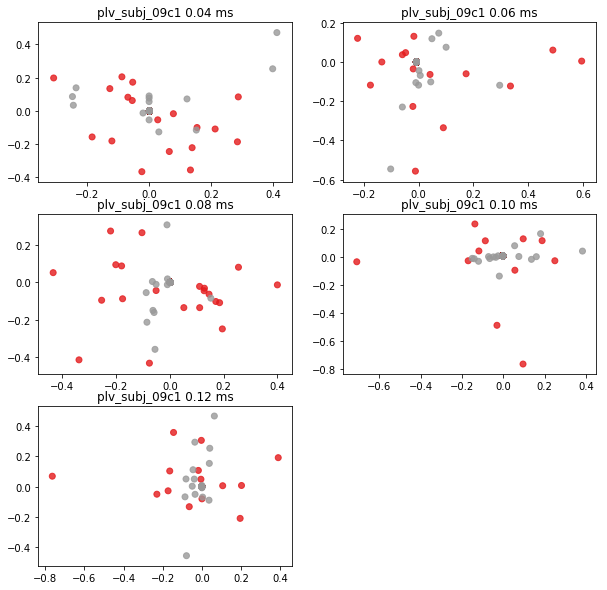

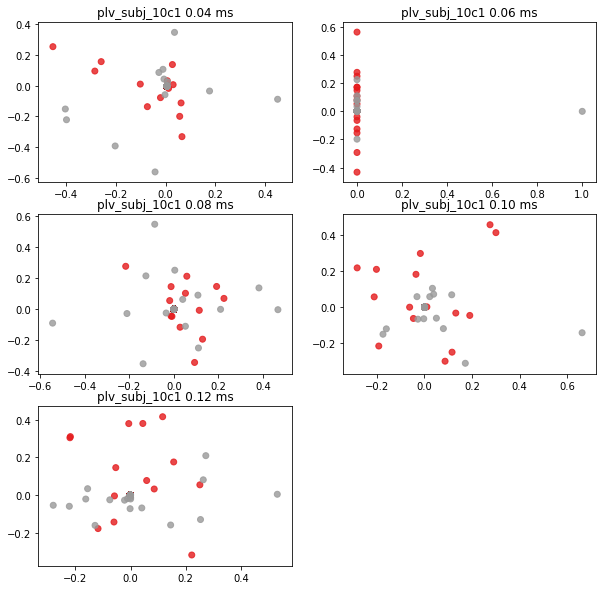

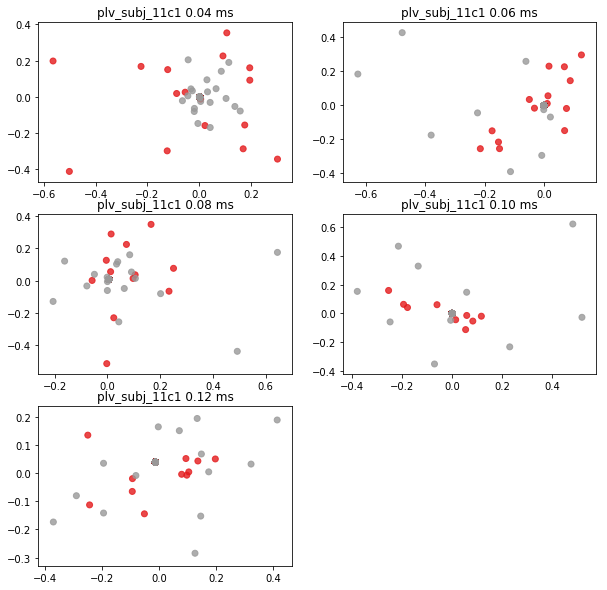

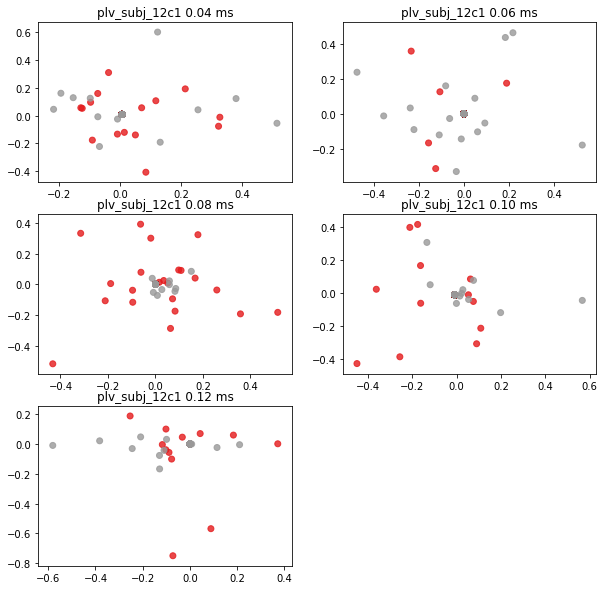

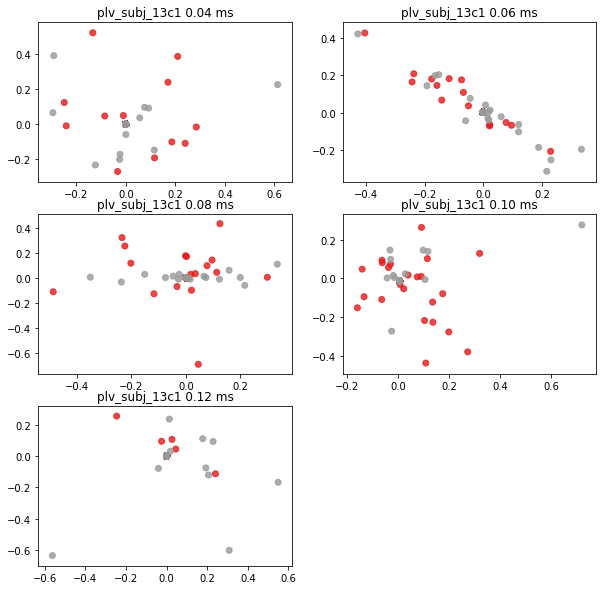

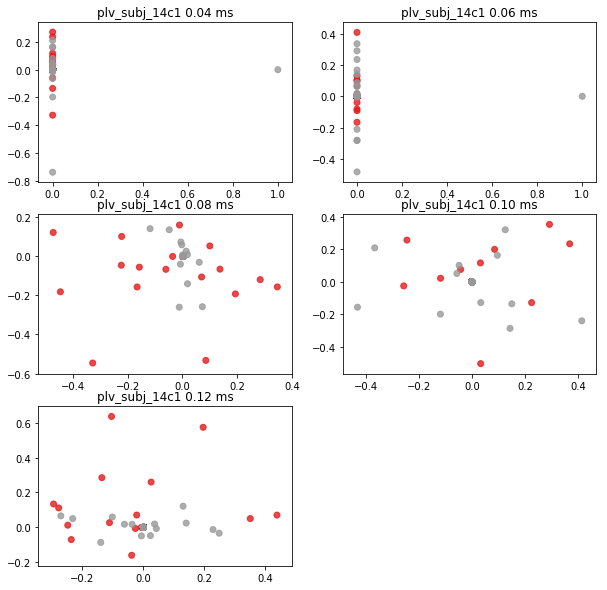

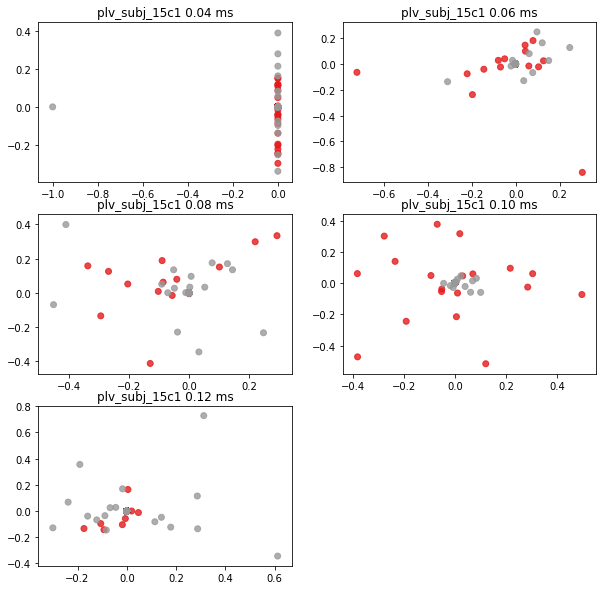

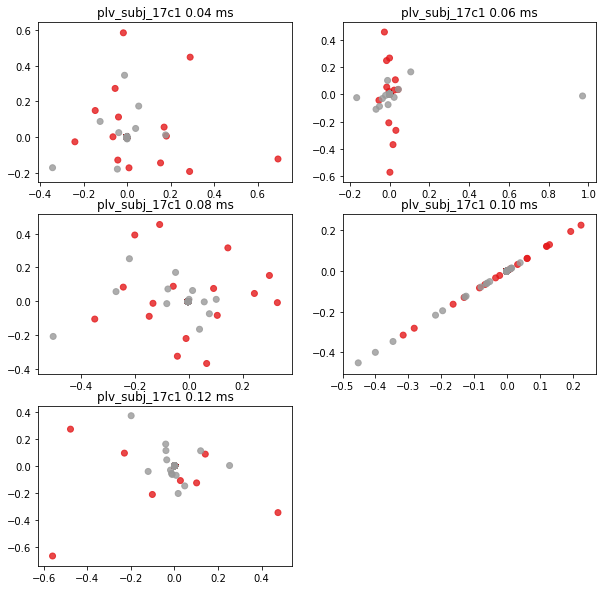

In [440]:
matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/spectrum-beta-29feb2016/2017/wideband/data_patients_beta_noselec_p50_Cz.mat'

filecontents = sio.whosmat(matfile)

for cursubjname in filecontents:
    current_subj = (cursubjname[0])
    subjdata = sio.loadmat(matfile,variable_names=current_subj,struct_as_record = False,squeeze_me=True)[current_subj]
    plt.figure(figsize=(10,10))
    
    for k,tpoint in enumerate(range(12,17)):

        tpoint_ms = subjdata.all.iso.standard.time[tpoint]
        p50_cz_iso_std = subjdata.all.iso.standard.ang[:,2,:,tpoint]
        p50_cz_rnd_std = subjdata.all.rnd.standard.ang[:,2,:,tpoint]

        #print("Examining at %0.2f ms" % tpoint_ms)

        n_iso = p50_cz_iso_std.shape[0]
        n_rnd = p50_cz_rnd_std.shape[0]
        #print(n_iso,n_rnd)

        y = 2*np.ones(n_iso+n_rnd)
        y[0:n_iso]=1

        X = (np.vstack([p50_cz_iso_std,p50_cz_rnd_std]))

        ####


        from sklearn.manifold import LocallyLinearEmbedding,Isomap,MDS,TSNE,SpectralEmbedding


        n_neighbors = 8
        n_components = 2

        #Y = Isomap(n_neighbors=n_neighbors,n_components=n_components).fit_transform(X)

        #Y = LocallyLinearEmbedding(n_neighbors,n_components=n_components,method='ltsa',eigen_solver='auto').fit_transform(X)

        #plt.scatter(Y[:, 0], Y[:, 1],c=y)
        #plt.title('ISOMAP')

        plt.subplot(3,2,k+1)

        #Y = MDS(n_components=n_components,metric=False).fit_transform((X))


        #Y = SpectralEmbedding(n_neighbors=n_neighbors,n_components=n_components).fit_transform(X)
        Y = LocallyLinearEmbedding(n_neighbors,n_components=n_components,method='ltsa',eigen_solver='dense').fit_transform(X)

        plt.scatter(Y[:, 0], Y[:, 1],c=y,alpha=0.8,cmap=plt.cm.Set1)
        plt.title('%s %0.2f ms' % (current_subj,tpoint_ms))

Learning 3D projections
--

Red points : REGULAR 

Grey points : IRREGULAR

In [426]:
from mpl_toolkits.mplot3d import Axes3D

Controls

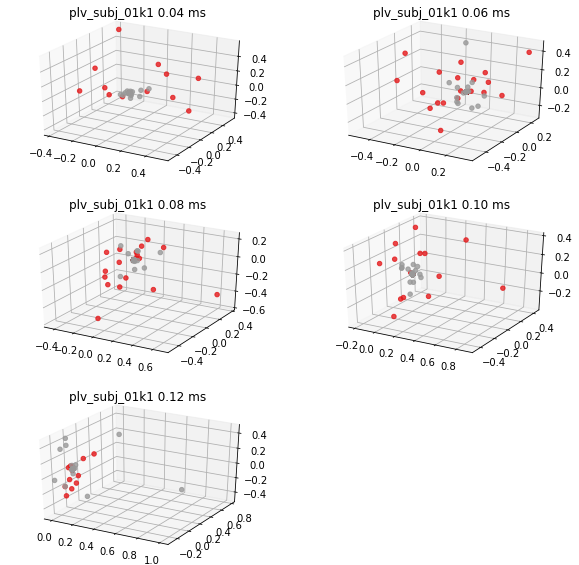

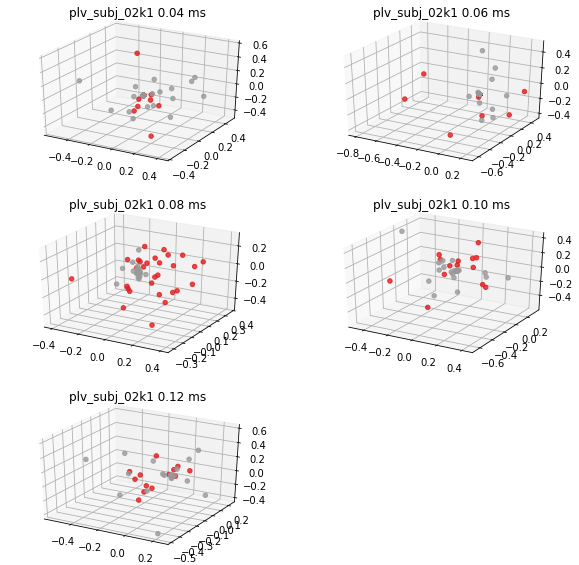

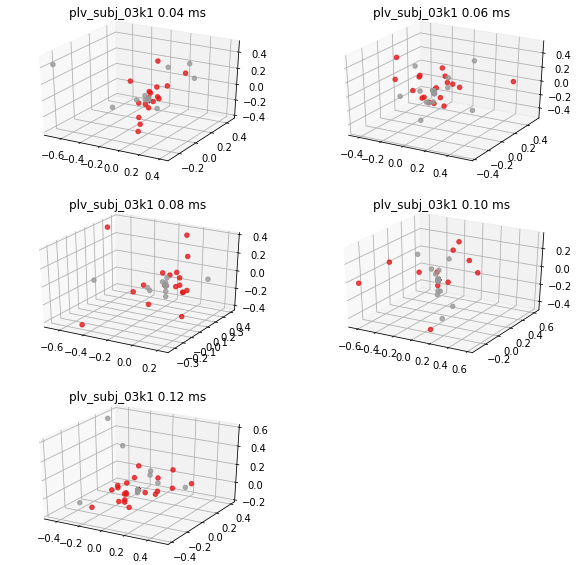

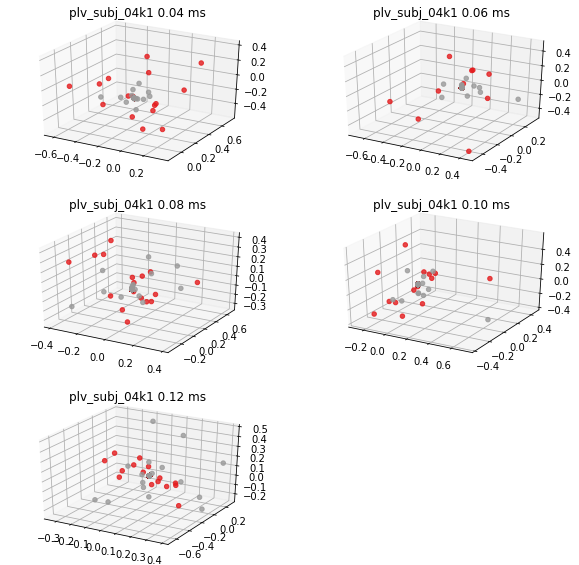

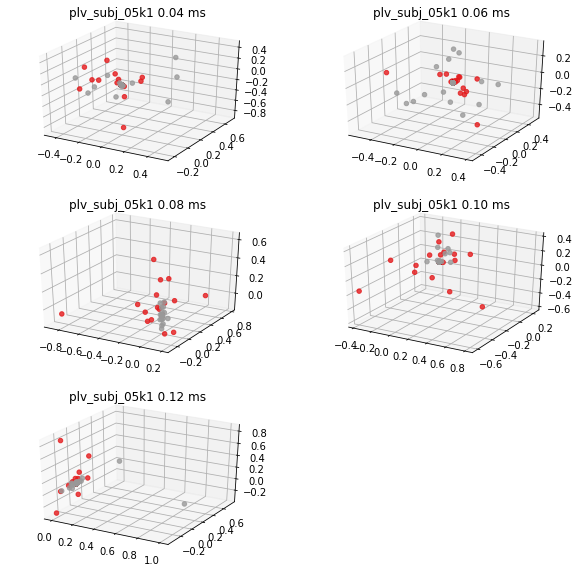

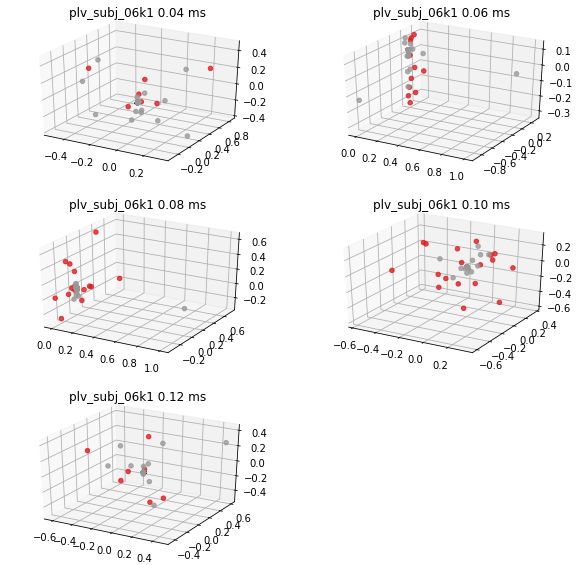

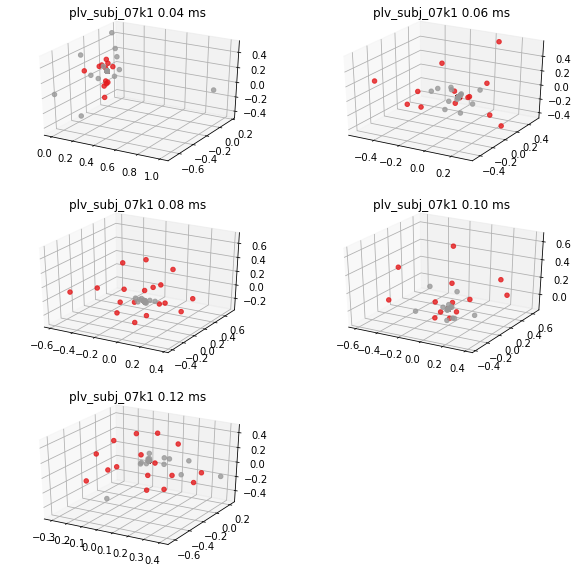

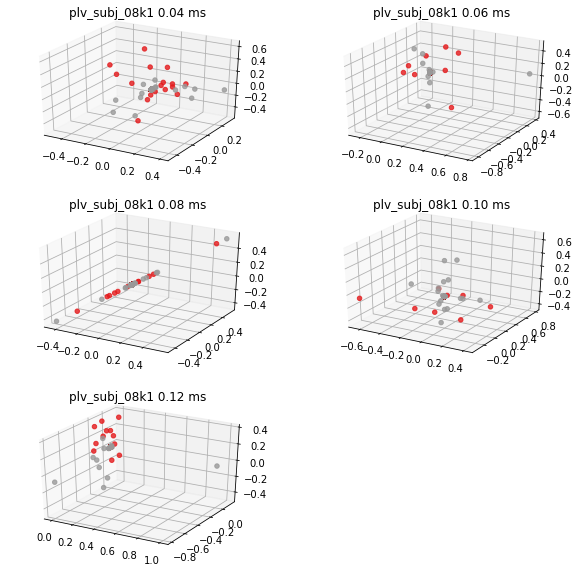

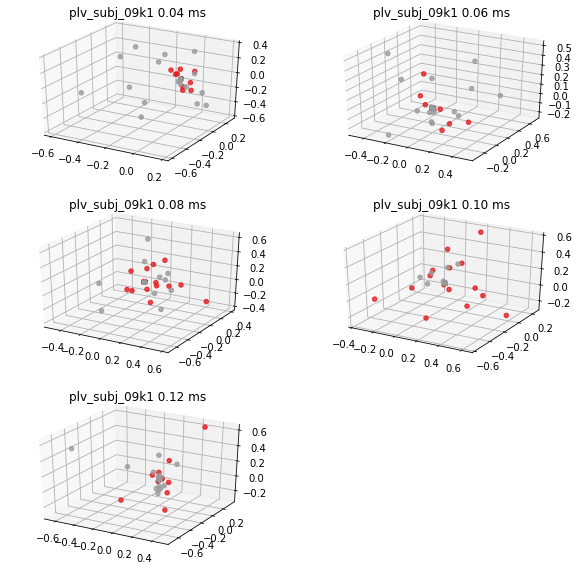

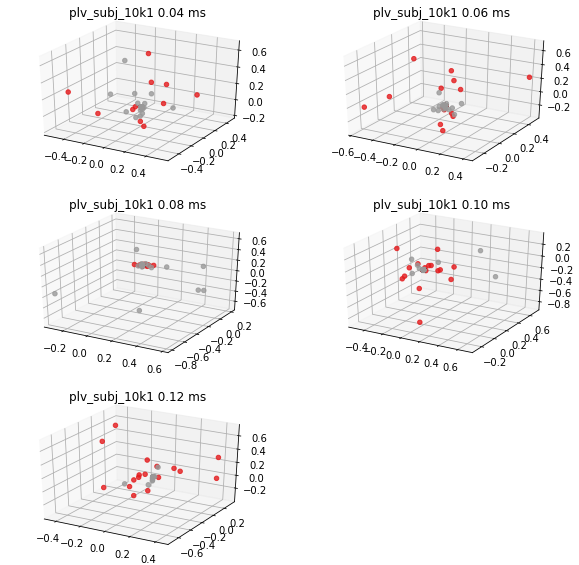

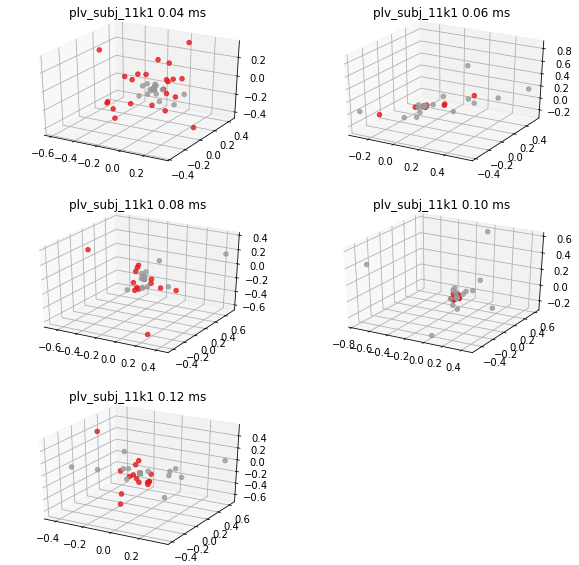

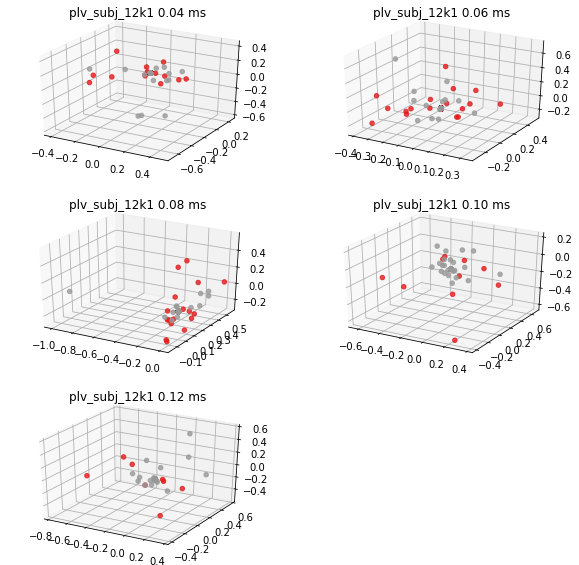

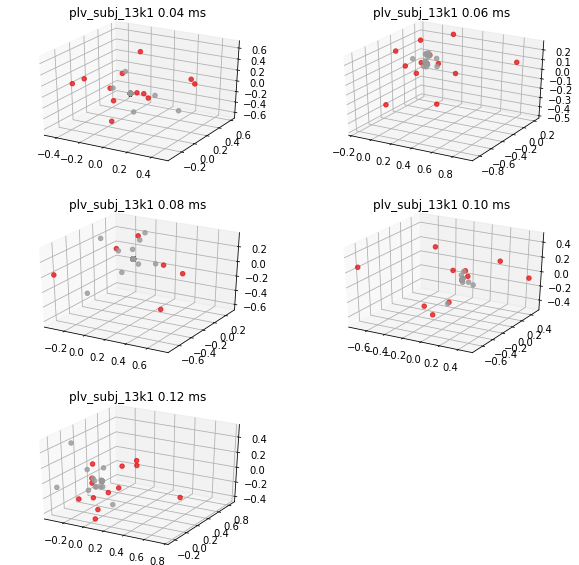

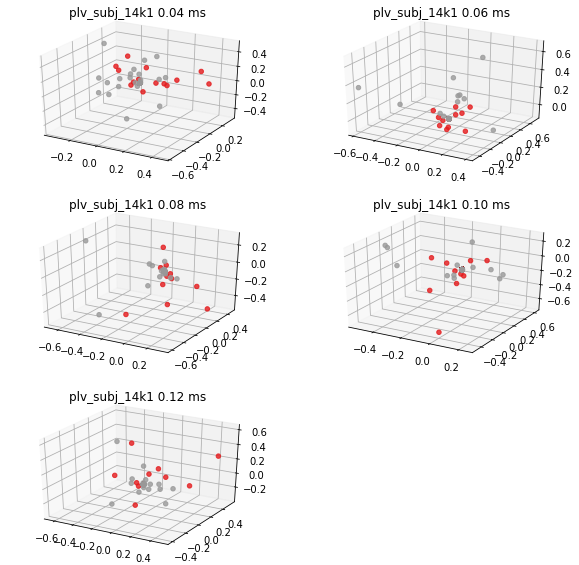

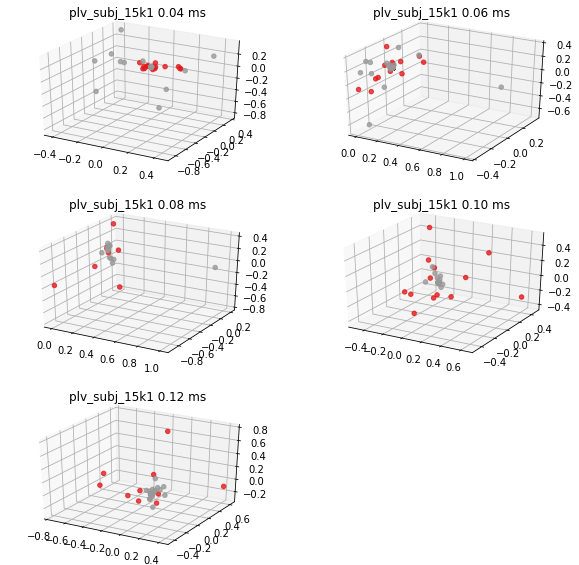

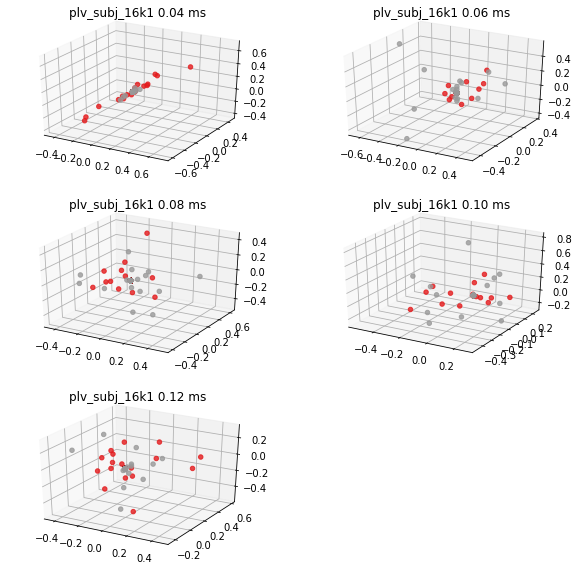

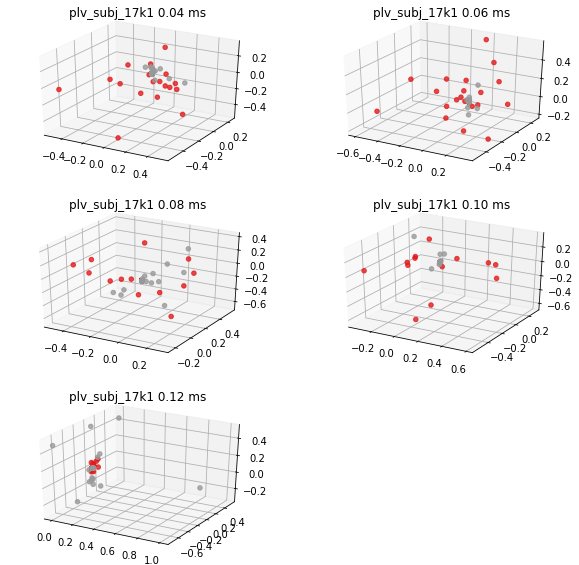

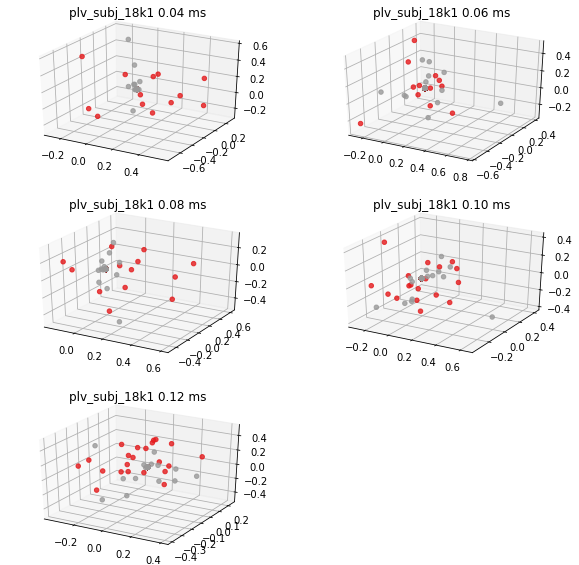

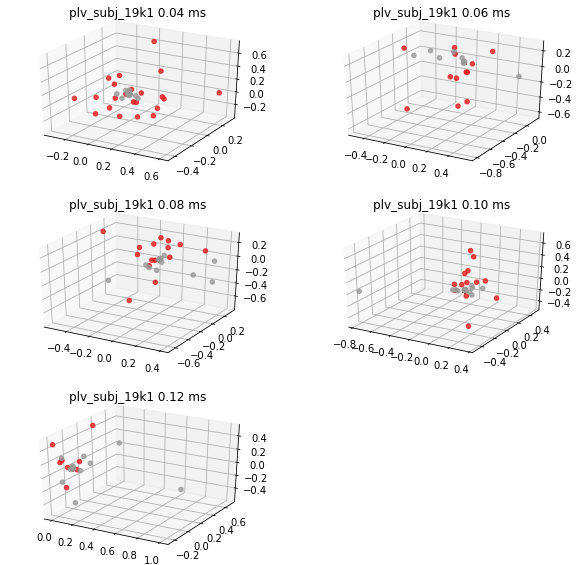

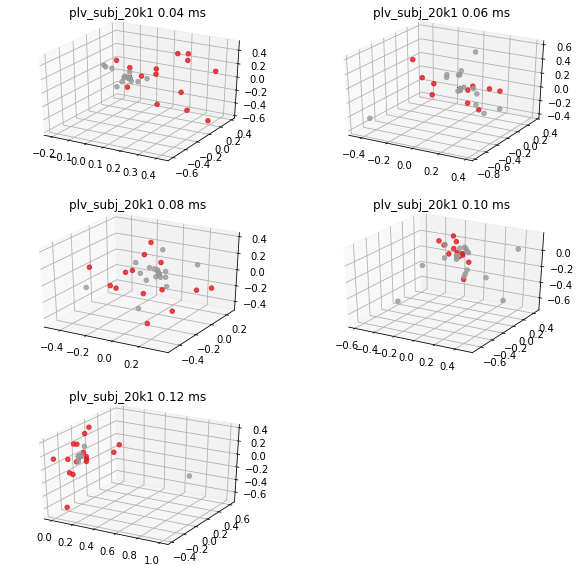

In [438]:
matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/spectrum-beta-29feb2016/2017/wideband/data_probands_beta_noselec_p50_Cz.mat'

filecontents = sio.whosmat(matfile)

for cursubjname in filecontents:
    current_subj = (cursubjname[0])
    subjdata = sio.loadmat(matfile,variable_names=current_subj,struct_as_record = False,squeeze_me=True)[current_subj]
    fig = plt.figure(figsize=(10,10))
    
    for k,tpoint in enumerate(range(12,17)):

        tpoint_ms = subjdata.all.iso.standard.time[tpoint]
        p50_cz_iso_std = subjdata.all.iso.standard.ang[:,2,:,tpoint]
        p50_cz_rnd_std = subjdata.all.rnd.standard.ang[:,2,:,tpoint]

        #print("Examining at %0.2f ms" % tpoint_ms)

        n_iso = p50_cz_iso_std.shape[0]
        n_rnd = p50_cz_rnd_std.shape[0]
        #print(n_iso,n_rnd)

        y = 2*np.ones(n_iso+n_rnd)
        y[0:n_iso]=1

        X = (np.vstack([p50_cz_iso_std,p50_cz_rnd_std]))


        from sklearn.manifold import LocallyLinearEmbedding,Isomap,MDS,TSNE,SpectralEmbedding
        n_neighbors = 8
        n_components = 3

        ax = fig.add_subplot(3,2,k+1,projection='3d')


        #Y = SpectralEmbedding(n_neighbors=n_neighbors,n_components=n_components,affinity='rbf').fit_transform(X)
        Y = LocallyLinearEmbedding(n_neighbors,n_components=n_components,method='ltsa',eigen_solver='dense').fit_transform(X)

        ax.scatter(Y[:, 0], Y[:, 1],Y[:,2],c=y,alpha=0.8,cmap=plt.cm.Set1)
        plt.title('%s %0.2f ms' % (current_subj,tpoint_ms))

Patients

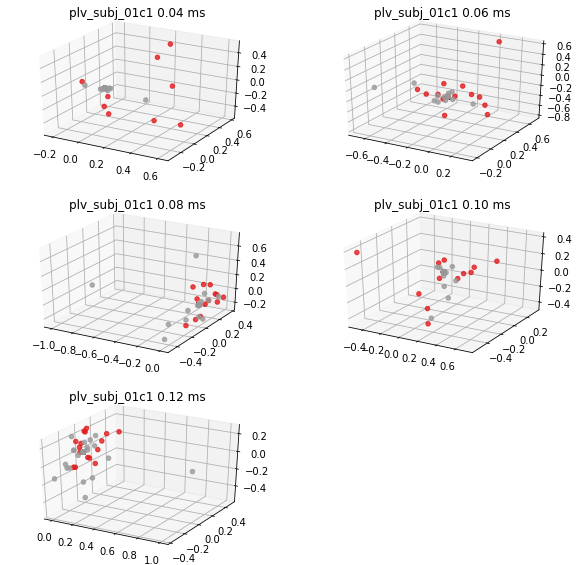

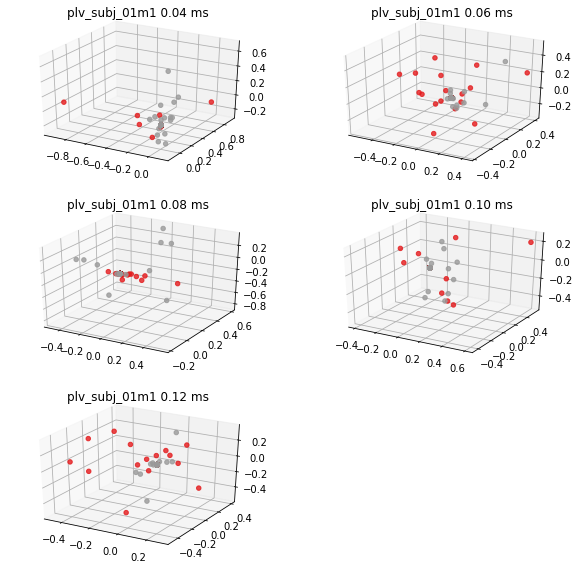

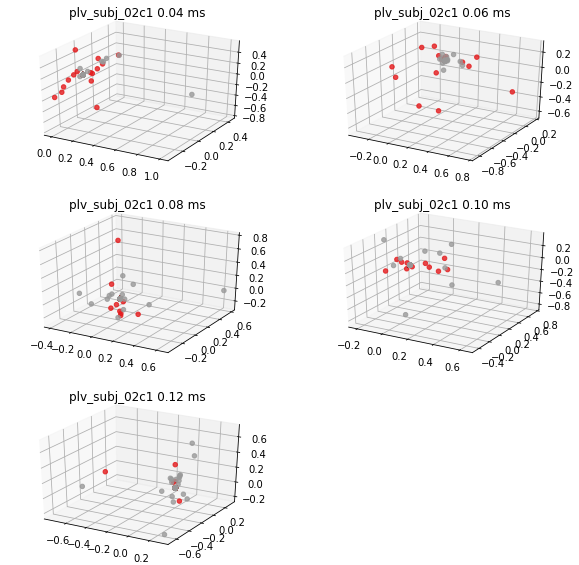

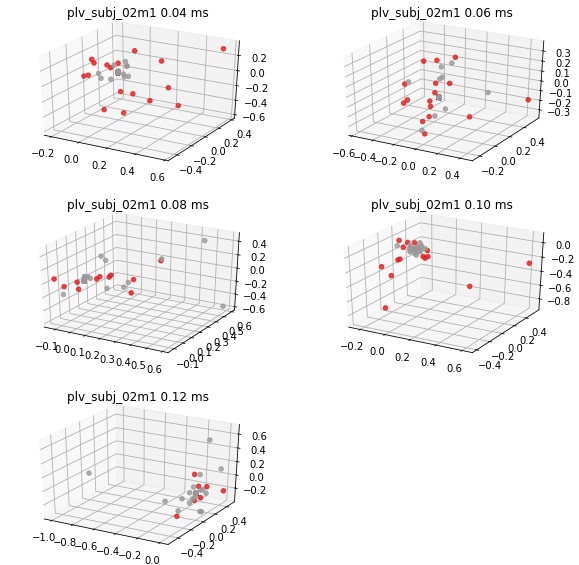

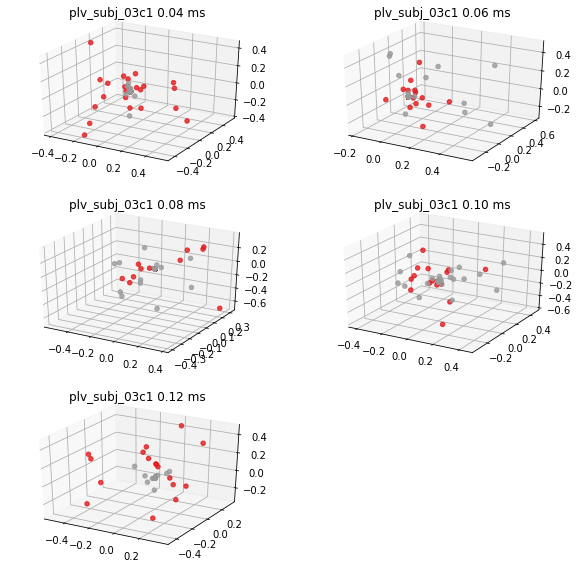

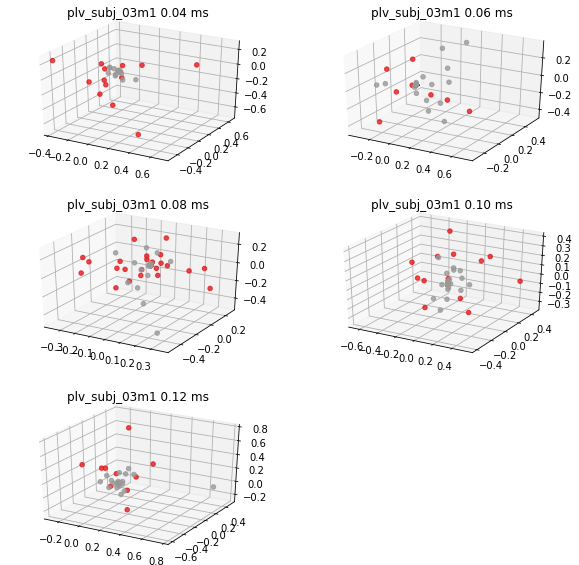

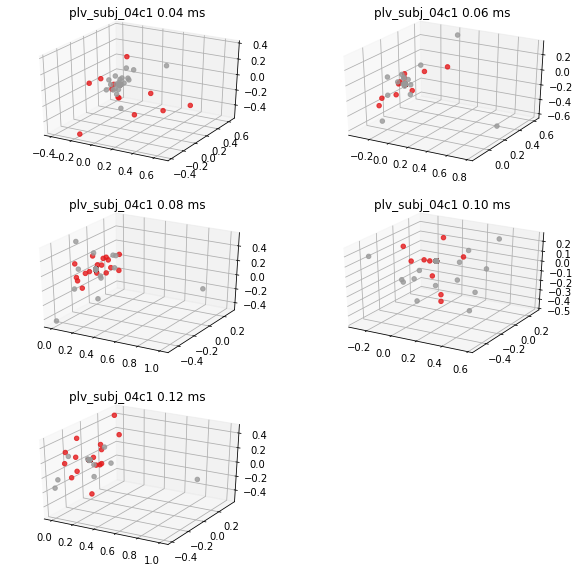

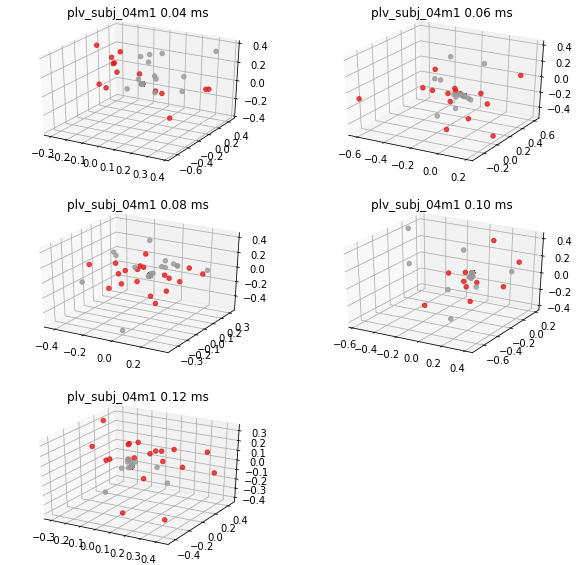

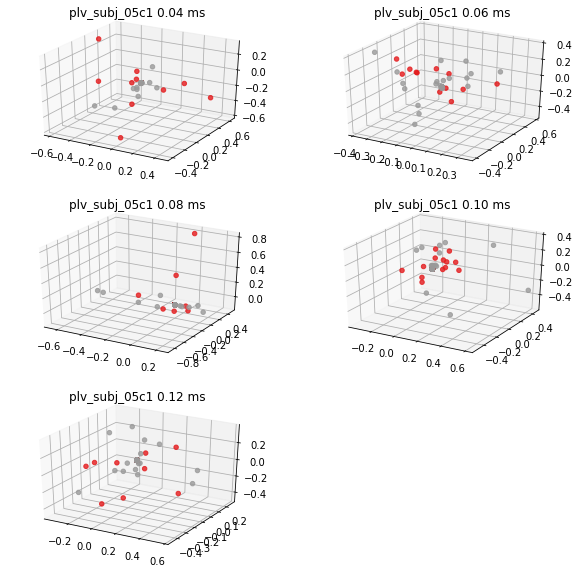

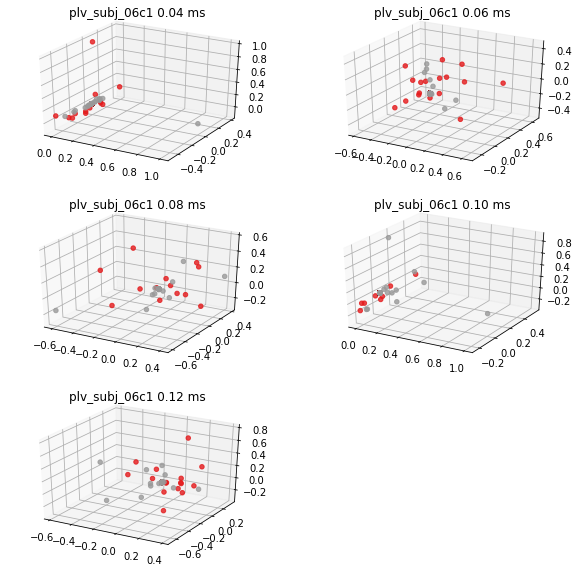

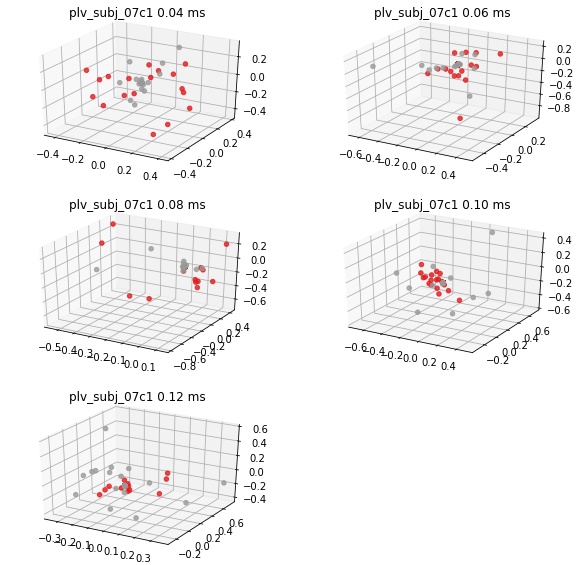

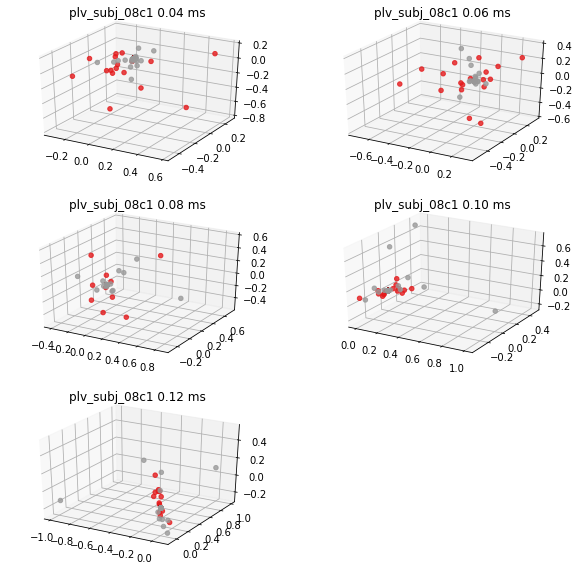

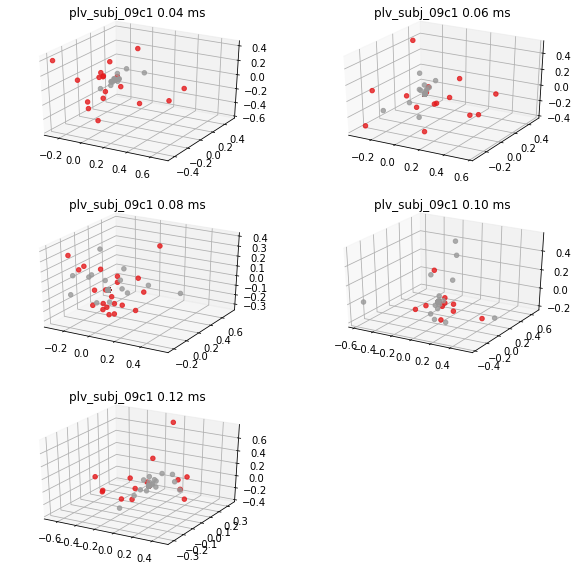

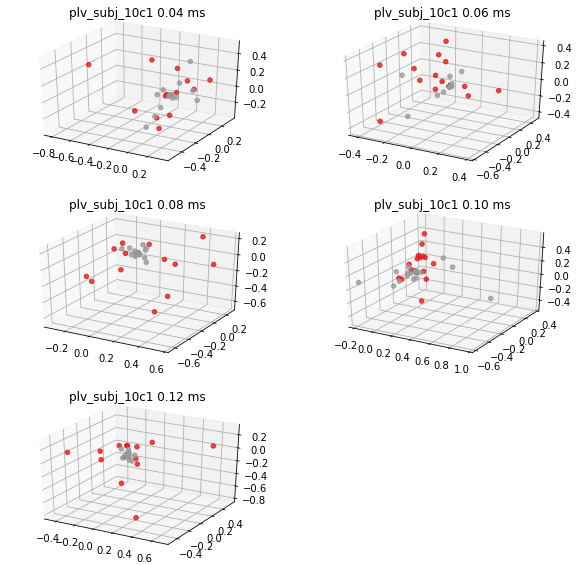

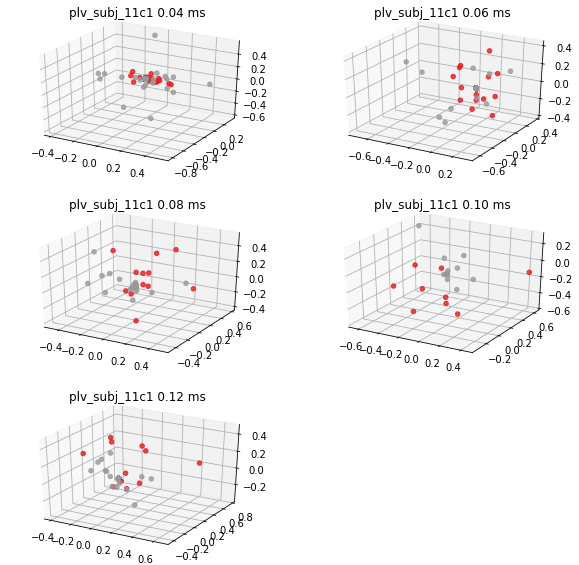

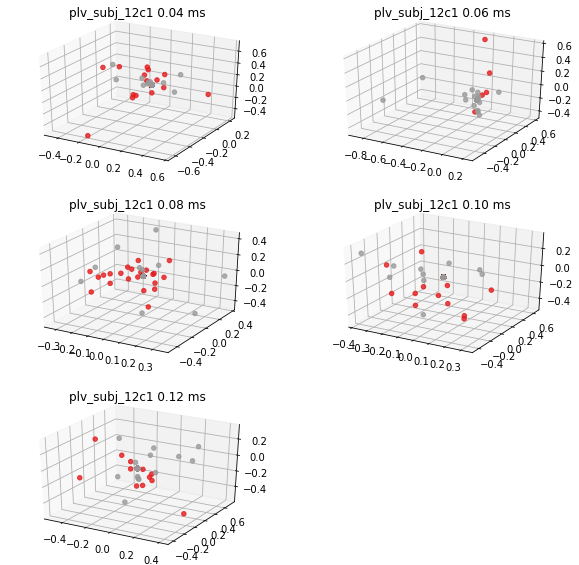

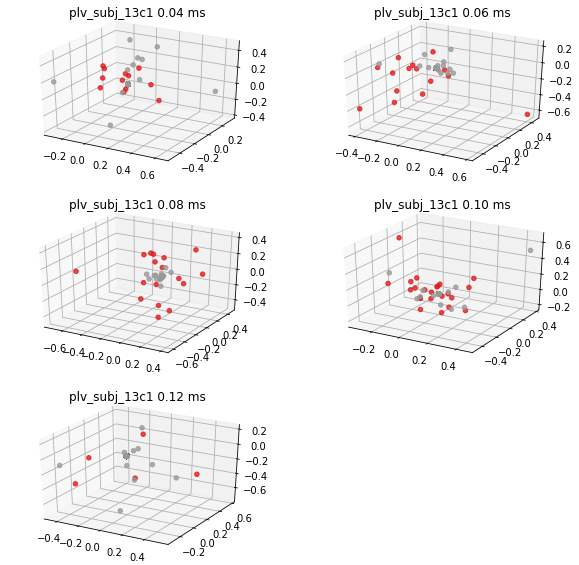

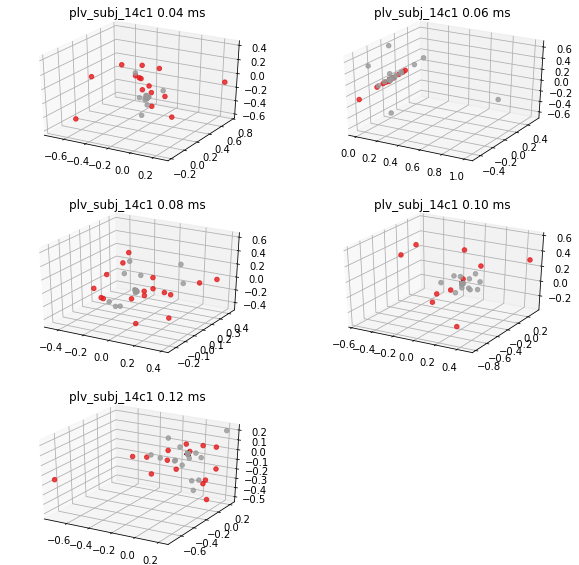

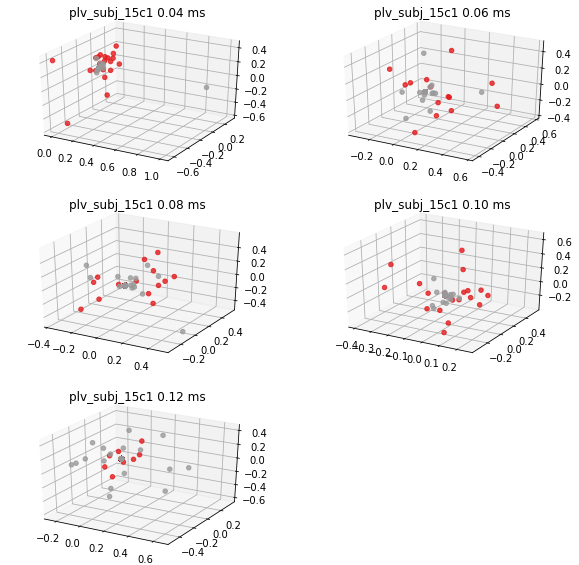

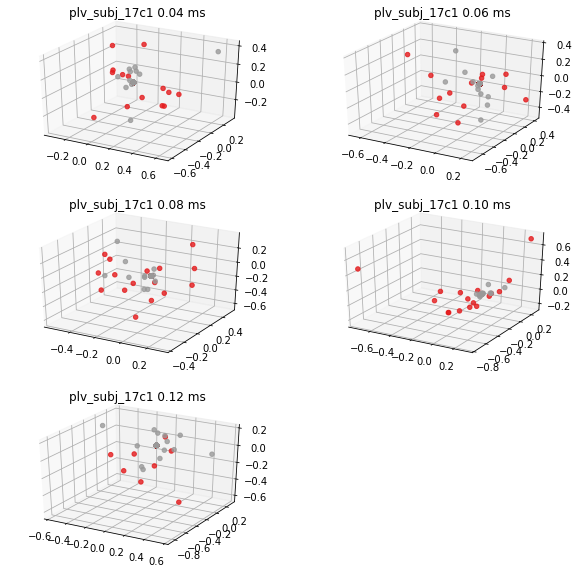

In [441]:
matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/spectrum-beta-29feb2016/2017/wideband/data_patients_beta_noselec_p50_Cz.mat'

filecontents = sio.whosmat(matfile)

for cursubjname in filecontents:
    current_subj = (cursubjname[0])
    subjdata = sio.loadmat(matfile,variable_names=current_subj,struct_as_record = False,squeeze_me=True)[current_subj]
    fig = plt.figure(figsize=(10,10))
    
    for k,tpoint in enumerate(range(12,17)):

        tpoint_ms = subjdata.all.iso.standard.time[tpoint]
        p50_cz_iso_std = subjdata.all.iso.standard.ang[:,2,:,tpoint]
        p50_cz_rnd_std = subjdata.all.rnd.standard.ang[:,2,:,tpoint]

        #print("Examining at %0.2f ms" % tpoint_ms)

        n_iso = p50_cz_iso_std.shape[0]
        n_rnd = p50_cz_rnd_std.shape[0]
        #print(n_iso,n_rnd)

        y = 2*np.ones(n_iso+n_rnd)
        y[0:n_iso]=1

        X = (np.vstack([p50_cz_iso_std,p50_cz_rnd_std]))


        from sklearn.manifold import LocallyLinearEmbedding,Isomap,MDS,TSNE,SpectralEmbedding
        n_neighbors = 8
        n_components = 3

        ax = fig.add_subplot(3,2,k+1,projection='3d')


        #Y = SpectralEmbedding(n_neighbors=n_neighbors,n_components=n_components,affinity='rbf').fit_transform(X)
        Y = LocallyLinearEmbedding(n_neighbors,n_components=n_components,method='ltsa',eigen_solver='dense').fit_transform(X)

        ax.scatter(Y[:, 0], Y[:, 1],Y[:,2],c=y,alpha=0.8,cmap=plt.cm.Set1)
        plt.title('%s %0.2f ms' % (current_subj,tpoint_ms))

Clustering tests using the whole group at once
--
to be continued - not stable yet 

/Users/nicolasfarrugia/miniconda3/envs/tf/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

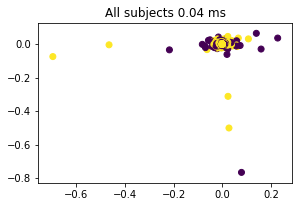

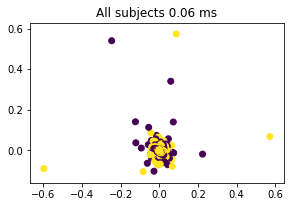

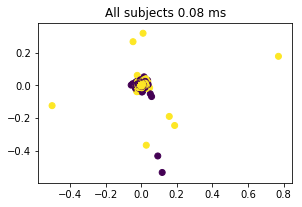

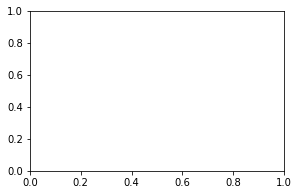

In [397]:
from sklearn.manifold import LocallyLinearEmbedding,Isomap,MDS,TSNE,SpectralEmbedding

for k,tpoint in enumerate(range(12,17)):
    X_all = []
    y_all = []
    plt.figure(figsize=(10,10))
    
    for cursubjname in filecontents:
    
        current_subj = (cursubjname[0])
        subjdata = sio.loadmat(matfile,variable_names=current_subj,struct_as_record = False,squeeze_me=True)[current_subj]
        

        tpoint_ms = subjdata.all.iso.standard.time[tpoint]
        p50_cz_iso_std = subjdata.all.iso.standard.ang[:,2,:,tpoint]
        p50_cz_rnd_std = subjdata.all.rnd.standard.ang[:,2,:,tpoint]

        
        n_iso = p50_cz_iso_std.shape[0]
        n_rnd = p50_cz_rnd_std.shape[0]
        #print(n_iso,n_rnd)

        y = 2*np.ones(n_iso+n_rnd)
        y[0:n_iso]=1

        X = (np.vstack([p50_cz_iso_std,p50_cz_rnd_std]))
        
        X_all.append(X)
        y_all.append(y)
        
    
    
    

    X_all = np.vstack(X_all)
    y_all = np.hstack(y_all)
    
    n_neighbors = 5
    n_components = 2

    #Y = Isomap(n_neighbors=n_neighbors,n_components=n_components).fit_transform(X)

    #Y = LocallyLinearEmbedding(n_neighbors,n_components=n_components,method='ltsa',eigen_solver='auto').fit_transform(X)

    #plt.scatter(Y[:, 0], Y[:, 1],c=y)
    #plt.title('ISOMAP')

    plt.subplot(3,2,k+1)

    #Y = MDS(n_components=n_components,metric=False).fit_transform((X))


    Y = LocallyLinearEmbedding(n_neighbors,n_components=n_components,method='ltsa',eigen_solver='dense').fit_transform(X_all)

    plt.scatter(Y[:, 0], Y[:, 1],c=y_all,alpha=1)
    plt.title('All subjects %0.2f ms' % (tpoint_ms))